In [1]:
!git clone https://github.com/Bhuvanesh-Singla/CropAndWeed.git

Cloning into 'CropAndWeed'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 214 (delta 5), reused 14 (delta 5), pack-reused 197 (from 2)
Receiving objects: 100% (214/214), 51.25 MiB | 32.12 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
!pip install -r "/kaggle/working/CropAndWeed/Final Flow/requirements.txt"

INFO: pip is looking at multiple versions of torchmetrics to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is still looking at multiple versions of torchmetrics to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.p

In [4]:
import sys
sys.path.append("/kaggle/working/CropAndWeed/Final Flow")

In [21]:
%%time
!python "/kaggle/working/CropAndWeed/Final Flow/pipeline.py" --plant_detector_config "/kaggle/working/CropAndWeed/Final Flow/nanodet_files/ViTnanodet/config/nanodet-plus-m_416-yolo-cpu.yml" \
--plant_detector_model "/kaggle/working/CropAndWeed/Final Flow/nanodet_files/ViTnanodet/saved_models/nanodet_model_best.pth" \
--weed_classifier_model "/kaggle/working/CropAndWeed/Final Flow/VIT_files/vit_tiny.pth" \
--image_path "/kaggle/input/cleaned-cv-dataset/images/ave-0035-0006.jpg"


model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.
/kaggle/working/CropAndWeed/Final Flow/VIT_files/vit_inference.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full con

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

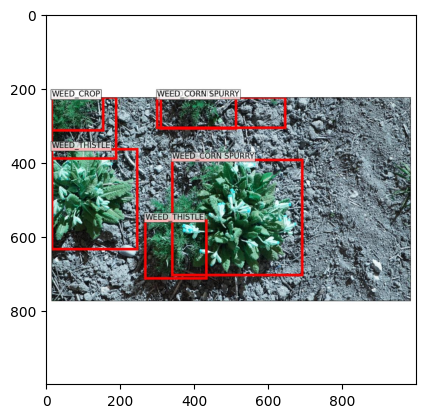

In [20]:
img = Image.open("/kaggle/working/annotated_image.jpg")
plt.imshow(img)